

**The step estimation module provided by the host is great, but sometimes it points to strange positions. That of the host uses TYPE_ROTATION_VECTOR. Therefore, by using it in combination with the estimation using TYPE_MAGNETIC_FIELD, the walking direction can be brought closer to the accurate one.**



Score improved 0.061 in this sub

6.062 →　6.001



This notebook demonstrates a post-processing strategy for the
[Indoor Location & Navigation](https://www.kaggle.com/c/indoor-location-navigation)
competition.

To combine machine learning (wifi features) predictions with sensor data (acceleration, attitude heading),
I defined cost function as follows,
$$
L(X_{1:N}) = \sum_{i=1}^{N} \alpha_i \| X_i - \hat{X}_i \|^2 + \sum_{i=1}^{N-1} \beta_i \| (X_{i+1} - X_{i}) - \Delta \hat{X}_i \|^2
$$
where $\hat{X}_i$ is absolute position predicted by machine learning and $\Delta \hat{X}_i$ is relative position predicted by sensor data.

Since the cost function is quadratic, the optimal $X$ is solved by linear equation $Q X = c$
, where $Q$ and $c$ are derived from above cost function.
Because the matrix $Q$ is tridiagonal,
each machine learning prediction is corrected by *all* machine learning predictions and sensor data.

The optimal hyperparameters ($\alpha$ and $\beta$) can be estimated by expected error of machine learning and sensor data,
or just tuned by public score.

## References
+ [Simple 99% Accurate Floor Model](https://www.kaggle.com/nigelhenry/simple-99-accurate-floor-model)
+ [Indoor Location Competition 2.0 (Sample Data and Code)](https://github.com/location-competition/indoor-location-competition-20)

In [1]:
# !git clone --depth 1 https://github.com/location-competition/indoor-location-competition-20 indoor_location_competition_20
# !rm -rf indoor_location_competition_20/data

In [2]:
import multiprocessing
import numpy as np
import pandas as pd
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm

from indoor_location_competition_20.io_f import read_data_file
import indoor_location_competition_20.compute_f as compute_f

# df_leak = pd.read_csv('../codeleak/df_leak.csv')
# sure_begin_end = list(df_leak[~df_leak.start_waypoint_x.isna()].path_id)

In [3]:
INPUT_PATH = '../input/indoor-location-navigation'

In [4]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions

In [5]:
import math

order = 3
fs = 50.0  # sample rate, Hz
# fs = 100
# cutoff = 3.667  # desired cutoff frequency of the filter, Hz
cutoff = 3

step_distance = 0.8
w_height = 1.7
m_trans = -5

In [6]:
from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [7]:
def peak_accel_threshold(data, timestamps, threshold):
    d_acc = []
    last_state = 'below'
    crest_troughs = 0
    crossings = []

    for i, datum in enumerate(data):
        
        current_state = last_state
        if datum < threshold:
            current_state = 'below'
        elif datum > threshold:
            current_state = 'above'

        if current_state is not last_state:
            if current_state is 'above':
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)
            else:
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)

            crest_troughs += 1
        last_state = current_state
    return np.array(crossings)

**The blending method is to halve the stride length and adopt all steps, the number of steps will be doubled, but here only the movement distance is required**

In [8]:
def steps_compute_rel_positions(sample_file):
    
    mix_acce = np.sqrt(sample_file.acce[:,1:2]**2 + sample_file.acce[:,2:3]**2 + sample_file.acce[:,3:4]**2)
    mix_acce = np.concatenate([sample_file.acce[:,0:1], mix_acce], 1)
    mix_df = pd.DataFrame(mix_acce)
    mix_df.columns = ["timestamp","acce"]
    
    filtered = butter_lowpass_filter(mix_df["acce"], cutoff, fs, order)

    threshold = filtered.mean() * 1.1
    crossings = peak_accel_threshold(filtered, mix_df["timestamp"], threshold)

    step_sum = len(crossings)/2
    distance = w_height * 0.4 * step_sum

    mag_df = pd.DataFrame(sample_file.magn)
    mag_df.columns = ["timestamp","x","y","z"]
    
    acce_df = pd.DataFrame(sample_file.acce)
    acce_df.columns = ["timestamp","ax","ay","az"]
    
    mag_df = pd.merge(mag_df,acce_df,on="timestamp")
    mag_df.dropna()
    
    time_di_list = []

    for i in mag_df.iterrows():

        gx,gy,gz = i[1][1],i[1][2],i[1][3]
        ax,ay,az = i[1][4],i[1][5],i[1][6]

        roll = math.atan2(ay,az)
        pitch = math.atan2(-1*ax , (ay * math.sin(roll) + az * math.cos(roll)))

        q = m_trans - math.degrees(math.atan2(
            (gz*math.sin(roll)-gy*math.cos(roll)),(gx*math.cos(pitch) + gy*math.sin(roll)*math.sin(pitch) + gz*math.sin(pitch)*math.cos(roll))
        )) -90
        if q <= 0:
            q += 360
        time_di_list.append((i[1][0],q))

    d_list = [x[1] for x in time_di_list]
    
    steps = []
    step_time = []
    di_dict = dict(time_di_list)

    for n,i in enumerate(crossings[:,:1]):
        if n % 2 == 1:
            continue
        direct_now = di_dict[i[0]]
        dx = math.sin(math.radians(direct_now))
        dy = math.cos(math.radians(direct_now))
#         print(int(n/2+1),"歩目/x:",dx,"/y:",dy,"/角度：",direct_now)
        steps.append((i[0],dx,dy))
        step_time.append(i[0])
    
        step_dtime = np.diff(step_time)/1000
        step_dtime = step_dtime.tolist()
        step_dtime.insert(0,5)
        
        rel_position = []

        wp_idx = 0
#         print("WP:",round(sample_file.waypoint[0,1],3),round(sample_file.waypoint[0,2],3),sample_file.waypoint[0,0])
#         print("------------------")
        for p,i in enumerate(steps):
            step_distance = 0
            if step_dtime[p] >= 1:
                step_distance = w_height*0.25
            elif step_dtime[p] >= 0.75:
                step_distance = w_height*0.3
            elif step_dtime[p] >= 0.5:
                step_distance = w_height*0.4
            elif step_dtime[p] >= 0.35:
                step_distance = w_height*0.45
            elif step_dtime[p] >= 0.2:
                step_distance = w_height*0.5
            else:
                step_distance = w_height*0.4

#             step_x += i[1]*step_distance
#             step_y += i[2]*step_distance
            
            rel_position.append([i[0], i[1]*step_distance, i[2]*step_distance])
#     print(rel_position)
    
    return np.array(rel_position)

In [9]:
def correct_path(args):
    path, path_df = args
    
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    
    example = read_data_file(f'{INPUT_PATH}/test/{path}.txt')

    rel_positions1 = compute_rel_positions(example.acce, example.ahrs)
    rel_positions2 = steps_compute_rel_positions(example)
    rel1 = rel_positions1.copy()
    rel2 = rel_positions2.copy()
    rel1[:,1:] = rel_positions1[:,1:] / 2
    rel2[:,1:] = rel_positions2[:,1:] / 2
    rel_positions = np.vstack([rel1,rel2])
#     rel_positions = rel_positions2.copy()
    rel_positions = rel_positions[np.argsort(rel_positions[:, 0])]
    
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)

#     if path in sure_begin_end:
#         alpha = (8.1)**(-2) * np.ones(N)
#         alpha[0] = 1
#         alpha[-1] = 1
#     else:
#         alpha = (8.1)**(-2) * np.ones(N)
        
#     index = np.arange(N)
#     np.random.shuffle(index)
#     alpha[index[:int(N/2)]] = 0

    alpha = (8.1)**(-2) * np.ones(N)
        
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
#     beta  = (4.1 + 4.1 * 1e-3 * delta_t)**(-2)

    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })

In [10]:

sub = pd.read_csv('sub_wifi_sensor.csv')


# df_leak = pd.read_csv('../codeleak/df_leak.csv')
# sure_begin_end = list(df_leak[~df_leak.start_waypoint_x.isna()].path_id)
# sub.shape

In [11]:
# df_sample = sub.copy()

# df_sample["site_id"] = df_sample["site_path_timestamp"].apply(lambda x:x.split('_')[0])
# df_sample["path_id"] = df_sample["site_path_timestamp"].apply(lambda x:x.split('_')[1])
# df_sample["timestamp"] = df_sample["site_path_timestamp"].apply(lambda x:x.split('_')[2]).astype(int)
# list_site = df_sample["site_id"].unique()

# df_leak = pd.read_csv('../codeleak/df_leak.csv')
# # apply leakage waypoint
# df_sub = df_sample.copy()
# list_path = df_sub["path_id"].unique()
# for path_id in tqdm(list_path):
#     df_sub_path = df_sub.query("path_id == @path_id")
#     start_idx = df_sub.loc[df_sub["path_id"] == path_id].index.min()
#     end_idx = df_sub.loc[df_sub["path_id"] == path_id].index.max()
#     start_x = df_sub_path.at[start_idx,"x"]
#     start_y = df_sub_path.at[start_idx,"y"]
#     end_x = df_sub_path.at[end_idx,"x"]
#     end_y = df_sub_path.at[end_idx,"y"]
#     start_x_leak = df_leak.query("path_id == @path_id")["start_waypoint_x"].iloc[0]
#     start_y_leak = df_leak.query("path_id == @path_id")["start_waypoint_y"].iloc[0]
#     end_x_leak = df_leak.query("path_id == @path_id")["end_waypoint_x"].iloc[0]
#     end_y_leak = df_leak.query("path_id == @path_id")["end_waypoint_y"].iloc[0]
#     if not np.isnan(start_x_leak):
#         df_sub.at[start_idx,"x"] = start_x_leak
#         df_sub.at[start_idx,"y"] = start_y_leak
#     if not np.isnan(end_x_leak):
#         df_sub.at[end_idx,"x"] = end_x_leak
#         df_sub.at[end_idx,"y"] = end_y_leak
        
# sub = df_sub.copy()[['site_path_timestamp', 'floor', 'x', 'y']]

In [12]:


tmp = sub['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
sub['site'] = tmp[0]
sub['path'] = tmp[1]
sub['timestamp'] = tmp[2].astype(float)



In [13]:
# def split_col(df):
#     df = pd.concat([
#         df['site_path_timestamp'].str.split('_', expand=True) \
#         .rename(columns={0:'site',
#                          1:'path',
#                          2:'timestamp'}),
#         df
#     ], axis=1).copy()
#     return df

# floor_map = {"B2":-2, "B1":-1, "F1":0, "F2": 1, "F3":2,
#              "F4":3, "F5":4, "F6":5, "F7":6,"F8":7,"F9":8,
#              "1F":0, "2F":1, "3F":2, "4F":3, "5F":4, "6F":5,
#              "7F":6, "8F": 7, "9F":8}

# if 'path' not in sub.columns:
#     sub = split_col(sub)

In [14]:
# import cv2
# if 'path' not in sub.columns:
#     sub = split_col(sub)
# path = '2b4bacedc942ffcb523ff20f'
# path = 'f4bd7479dbe91f3d18f44c49'
# subpart = sub[sub.path==path].copy()#[['x','y']]
# site = subpart.loc[subpart.index[0],'site']

# try:
#     map_floor = floor_map_inv1[subpart.loc[subpart.index[0],'floor']]
#     base="../input/indoor-location-navigation"
#     floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
#     json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
#     with open(json_plan_filename) as json_file:
#         json_data = json.load(json_file)
#     floor_img = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
#     img_cv = cv2.imread(floor_img)
#     #print(site,path,map_floor)
# except:
#     map_floor = floor_map_inv2[subpart.loc[subpart.index[0],'floor']]
#     base="../input/indoor-location-navigation"
#     floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
#     json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
#     with open(json_plan_filename) as json_file:
#         json_data = json.load(json_file)
#     floor_img = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
#     img_cv = cv2.imread(floor_img)    
#     #print(site,path,map_floor)
    
# fig, ax = plt.subplots(figsize=(16, 16))
# plt.imshow(img_cv)
# subpart = sub[sub.path==path][['x','y']]
# width_meter = json_data["map_info"]["width"]
# height_meter = json_data["map_info"]["height"]
# print(img_cv.shape[0],img_cv.shape[1],height_meter,width_meter)
# subpart["x_"] = subpart["x"] * img_cv.shape[0] / height_meter
# subpart["y_"] = (
#     subpart["y"] * -1 * img_cv.shape[1] / width_meter
# ) + img_cv.shape[0]
# subpart["x_"] = np.clip(subpart["x_"],0,img_cv.shape[1]-10)
# subpart["y_"] = np.clip(subpart["y_"],0,img_cv.shape[0]-10)

# subpart["_x_"] = subpart["x_"] / img_cv.shape[0] * height_meter
# subpart["_y_"] = (subpart["y_"] - img_cv.shape[0])*width_meter/img_cv.shape[1]/(-1)

# plt.plot(subpart['x_'],subpart['y_'],'*-')
# plt.plot(range(0,800),[725]*800,'r-')

In [15]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, sub.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
sub = pd.concat(dfs).sort_values('site_path_timestamp')
# sub.to_csv('submission.csv', index=False)

626it [01:42,  6.13it/s]


In [16]:
# import cv2

# if 'path' not in sub.columns:
#     sub = split_col(sub)
# path = '2b4bacedc942ffcb523ff20f'
# path = 'f4bd7479dbe91f3d18f44c49'
# subpart = sub[sub.path==path].copy()#[['x','y']]
# site = subpart.loc[subpart.index[0],'site']

# try:
#     map_floor = floor_map_inv1[subpart.loc[subpart.index[0],'floor']]
#     base="../input/indoor-location-navigation"
#     floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
#     json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
#     with open(json_plan_filename) as json_file:
#         json_data = json.load(json_file)
#     floor_img = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
#     img_cv = cv2.imread(floor_img)
#     #print(site,path,map_floor)
# except:
#     map_floor = floor_map_inv2[subpart.loc[subpart.index[0],'floor']]
#     base="../input/indoor-location-navigation"
#     floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
#     json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
#     with open(json_plan_filename) as json_file:
#         json_data = json.load(json_file)
#     floor_img = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
#     img_cv = cv2.imread(floor_img)    
#     #print(site,path,map_floor)
    
# fig, ax = plt.subplots(figsize=(16, 16))
# plt.imshow(img_cv)
# subpart = sub[sub.path==path][['x','y']]
# width_meter = json_data["map_info"]["width"]
# height_meter = json_data["map_info"]["height"]
# print(img_cv.shape[0],img_cv.shape[1],height_meter,width_meter)
# subpart["x_"] = subpart["x"] * img_cv.shape[0] / height_meter
# subpart["y_"] = (
#     subpart["y"] * -1 * img_cv.shape[1] / width_meter
# ) + img_cv.shape[0]
# subpart["x_"] = np.clip(subpart["x_"],0,img_cv.shape[1]-10)
# subpart["y_"] = np.clip(subpart["y_"],0,img_cv.shape[0]-10)

# subpart["_x_"] = subpart["x_"] / img_cv.shape[0] * height_meter
# subpart["_y_"] = (subpart["y_"] - img_cv.shape[0])*width_meter/img_cv.shape[1]/(-1)

# plt.plot(subpart['x_'],subpart['y_'],'*-')
# plt.plot(range(0,800),[725]*800,'r-')

In [17]:
import cv2

def plot_floor_info(sub,path):
    subpart = sub[sub.path==path].copy()#[['x','y']]
    site = subpart.loc[subpart.index[0],'site']

    try:
        map_floor = floor_map_inv1[subpart.loc[subpart.index[0],'floor']]
        base="../input/indoor-location-navigation"
        floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
        json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
        print(json_plan_filename)
        with open(json_plan_filename) as json_file:
            json_data = json.load(json_file)
        floor_img = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
        img_cv = plt.imread(floor_img)
        #img_cv = cv2.imread(floor_img)
        #print(site,path,map_floor)
    except:
        map_floor = floor_map_inv2[subpart.loc[subpart.index[0],'floor']]
        base="../input/indoor-location-navigation"
        floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
        json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
        print(json_plan_filename)

        with open(json_plan_filename) as json_file:
            json_data = json.load(json_file)
        floor_img = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
        img_cv = plt.imread(floor_img)
        #img_cv = cv2.imread(floor_img)    
        #print(site,path,map_floor)

    fig, ax = plt.subplots(figsize=(16, 16))
    plt.imshow(img_cv)
    subpart = sub[sub.path==path][['x','y']]
    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]
    print(img_cv.shape[0],img_cv.shape[1],height_meter,width_meter)
    subpart["x_"] = subpart["x"] * img_cv.shape[0] / height_meter
    subpart["y_"] = (
        subpart["y"] * -1 * img_cv.shape[1] / width_meter
    ) + img_cv.shape[0]
    subpart["x_"] = np.clip(subpart["x_"],0,img_cv.shape[1]-10)
    subpart["y_"] = np.clip(subpart["y_"],0,img_cv.shape[0]-10)

    subpart["_x_"] = subpart["x_"] / img_cv.shape[0] * height_meter
    subpart["_y_"] = (subpart["y_"] - img_cv.shape[0])*width_meter/img_cv.shape[1]/(-1)

    plt.plot(subpart['x_'],subpart['y_'],'*-')
def split_col(df):
    df = pd.concat([
        df['site_path_timestamp'].str.split('_', expand=True) \
        .rename(columns={0:'site',
                         1:'path',
                         2:'timestamp'}),
        df
    ], axis=1).copy()
    return df
floor_map_inv1 = {-2: 'B2',
 -1: 'B1',
 0: 'F1',
 1: 'F2',
 2: 'F3',
 3: 'F4',
 4: 'F5',
 5: 'F6',
 6: 'F7',
 7: 'F8',
 8: 'F9'}
import json
from matplotlib import pyplot as plt

../input/indoor-location-navigation/metadata/5dbc1d84c1eb61796cf7c010/F2/floor_info.json
742 800 219.74676479990106 236.71181213998395


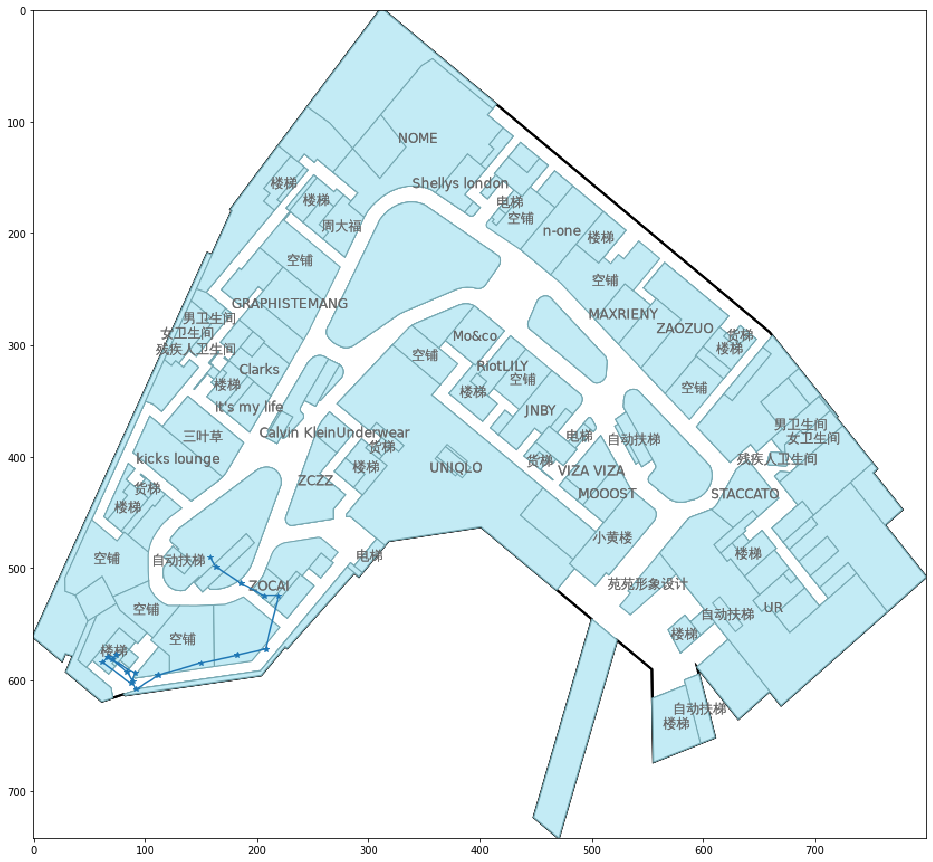

In [18]:
path = 'e8ed3f22ef83d9515ce36e8f'
sub_adjust = sub.copy()
if 'path' not in sub_adjust.columns:
    sub_adjust = split_col(sub_adjust).copy()
    sub_adjust['timestamp'] = sub_adjust['timestamp'].astype(int)
path_df = sub_adjust[sub_adjust.path==path].copy()
plot_floor_info(path_df,path)

In [19]:
sub.head()

,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,92.331508,96.874405
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,82.823625,99.323732
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,84.460441,104.374659
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.238622,108.135209
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.702916,111.851446


In [22]:
#####snap to grid

In [23]:
# Helper Functions
import pandas as pd
import numpy as np

import json
import matplotlib.pylab as plt

def split_col(df):
    df = pd.concat([
        df['site_path_timestamp'].str.split('_', expand=True) \
        .rename(columns={0:'site',
                         1:'path',
                         2:'timestamp'}),
        df
    ], axis=1).copy()
    return df

floor_map = {"B2":-2, "B1":-1, "F1":0, "F2": 1, "F3":2,
             "F4":3, "F5":4, "F6":5, "F7":6,"F8":7,"F9":8,
             "1F":0, "2F":1, "3F":2, "4F":3, "5F":4, "6F":5,
             "7F":6, "8F": 7, "9F":8}


def plot_preds(
    site,
    floorNo,
    sub=None,
    true_locs=None,
    base="../input/indoor-location-navigation",
    show_train=True,
    show_preds=True,
    fix_labels=True,
    map_floor=None
):
    """
    Plots predictions on floorplan map.
    
    map_floor : use a different floor's map
    """
    if map_floor is None:
        map_floor = floorNo
    # Prepare width_meter & height_meter (taken from the .json file)
    floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
    json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
    with open(json_plan_filename) as json_file:
        json_data = json.load(json_file)

    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    floor_img = plt.imread(f"{base}/metadata/{site}/{map_floor}/floor_image.png")

    fig, ax = plt.subplots(figsize=(12, 12))
    plt.imshow(floor_img)

    if show_train:
        true_locs = true_locs.query('site == @site and floorNo == @map_floor').copy()
        true_locs["x_"] = true_locs["x"] * floor_img.shape[0] / height_meter
        true_locs["y_"] = (
            true_locs["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        true_locs.query("site == @site and floorNo == @map_floor").groupby("path").plot(
            x="x_",
            y="y_",
            style="+",
            ax=ax,
            label="train waypoint location",
            color="grey",
            alpha=0.5,
        )

    if show_preds:
        sub = sub.query('site == @site and floorNo == @floorNo').copy()
        sub["x_"] = sub["x"] * floor_img.shape[0] / height_meter
        sub["y_"] = (
            sub["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        for path, path_data in sub.query(
            "site == @site and floorNo == @floorNo"
        ).groupby("path"):
            path_data.plot(
                x="x_",
                y="y_",
                style=".-",
                ax=ax,
                title=f"{site} - floor - {floorNo}",
                alpha=1,
                label=path,
            )
    if fix_labels:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(
            by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
        )
    return fig, ax

def sub_process(sub, train_waypoints):
    train_waypoints['isTrainWaypoint'] = True
    sub = split_col(sub[['site_path_timestamp','floor','x','y']]).copy()
    print(sub.shape)
    sub = sub.merge(train_waypoints[train_waypoints.path!='hand'][['site','floorNo','floor']].drop_duplicates(), how='left')
    print(sub.shape)
    sub = sub.merge(
        train_waypoints[['x','y','site','floor','isTrainWaypoint']].drop_duplicates(),
        how='left',
        on=['site','x','y','floor']
             )
    print(sub.shape)
    sub['isTrainWaypoint'] = sub['isTrainWaypoint'].fillna(False)
    return sub.copy()

In [24]:
train_waypoints = pd.read_csv('../input/indoor-location-train-waypoints/train_waypoints.csv')


In [25]:
train_waypoints.head(2)

,type_name,x,y,timestamp,site,floorNo,floor,path
0,TYPE_WAYPOINT,135.58220,51.289444,1573187328401,5da138274db8ce0c98bbd3d2,F3,2,5dc4f878171e610006b5d8ad
1,TYPE_WAYPOINT,142.69675,59.471970,1573187338226,5da138274db8ce0c98bbd3d2,F3,2,5dc4f878171e610006b5d8ad


In [26]:
# sub = pd.read_csv('rnn_xy_sub_3.328802_25.csv')
# sub = sub_process(sub, train_waypoints)
sub = sub_process(sub, train_waypoints)


(10133, 7)
(10133, 8)
(10133, 9)


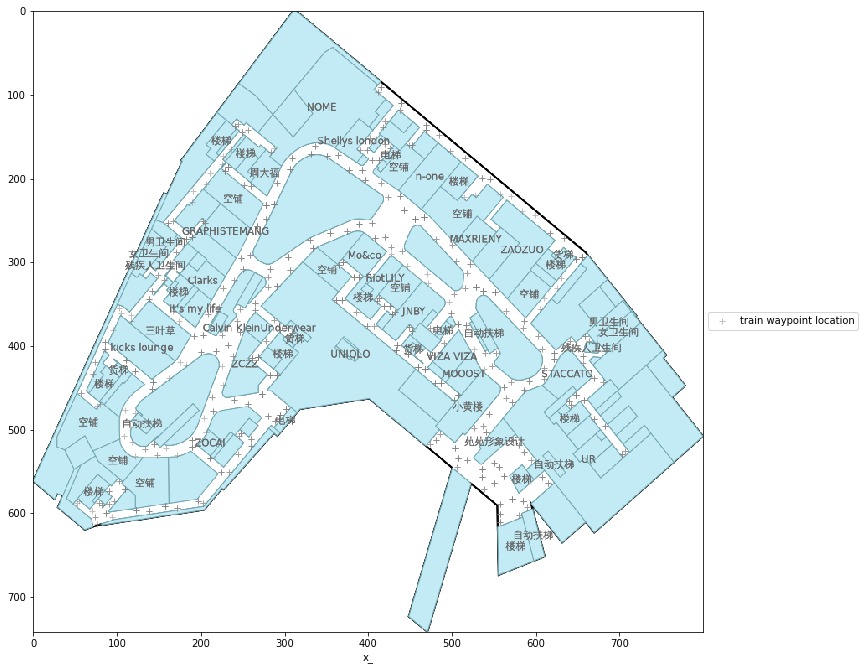

In [27]:

# Plot the training Data For an example Floor
example_site = '5dbc1d84c1eb61796cf7c010'
example_floorNo = 'F2'



plot_preds(example_site, example_floorNo, sub,
           train_waypoints, show_preds=False)
plt.show()

In [28]:
from scipy.spatial.distance import cdist

def add_xy(df):
    df['xy'] = [(x, y) for x,y in zip(df['x'], df['y'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

sub = add_xy(sub)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in sub.groupby(['site','floor']):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

sub = pd.concat(ds)

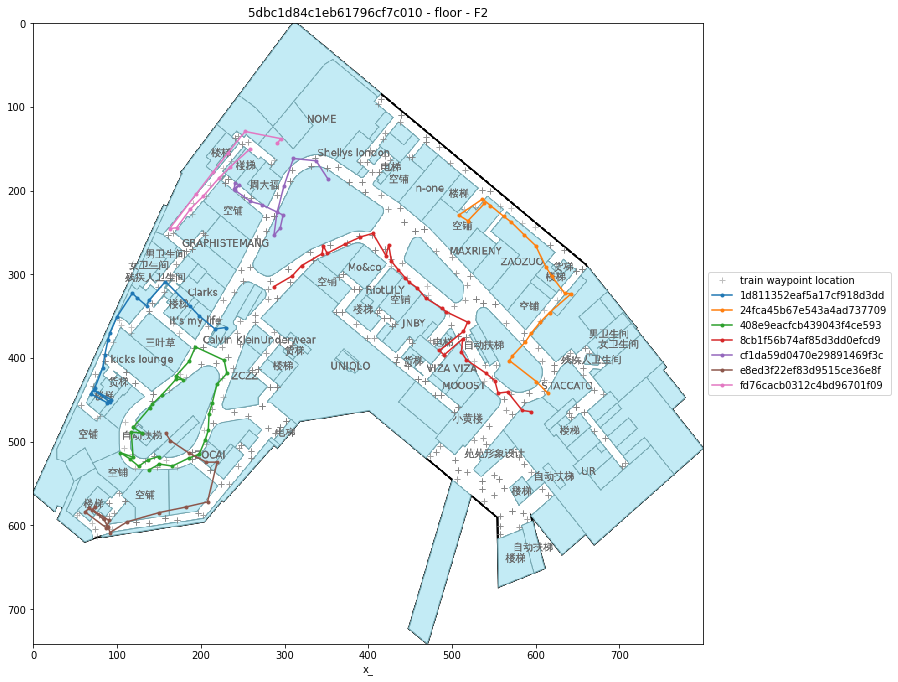

In [29]:
# Example of raw predictions
plot_preds(example_site, example_floorNo, sub,
           train_waypoints, show_preds=True)
plt.show()

In [30]:
def snap_to_grid(sub, threshold):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_x_'] = sub['x']
    sub['_y_'] = sub['y']
    sub.loc[sub['dist'] < threshold, '_x_'] = sub.loc[sub['dist'] < threshold]['x_']
    sub.loc[sub['dist'] < threshold, '_y_'] = sub.loc[sub['dist'] < threshold]['y_']
    return sub.copy()

# Calculate the distances
sub['dist'] = np.sqrt( (sub.x-sub.x_)**2 + (sub.y-sub.y_)**2 )

sub_pp = snap_to_grid(sub, threshold=5)

sub_pp = sub_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
    .rename(columns={'_x_':'x', '_y_':'y'})

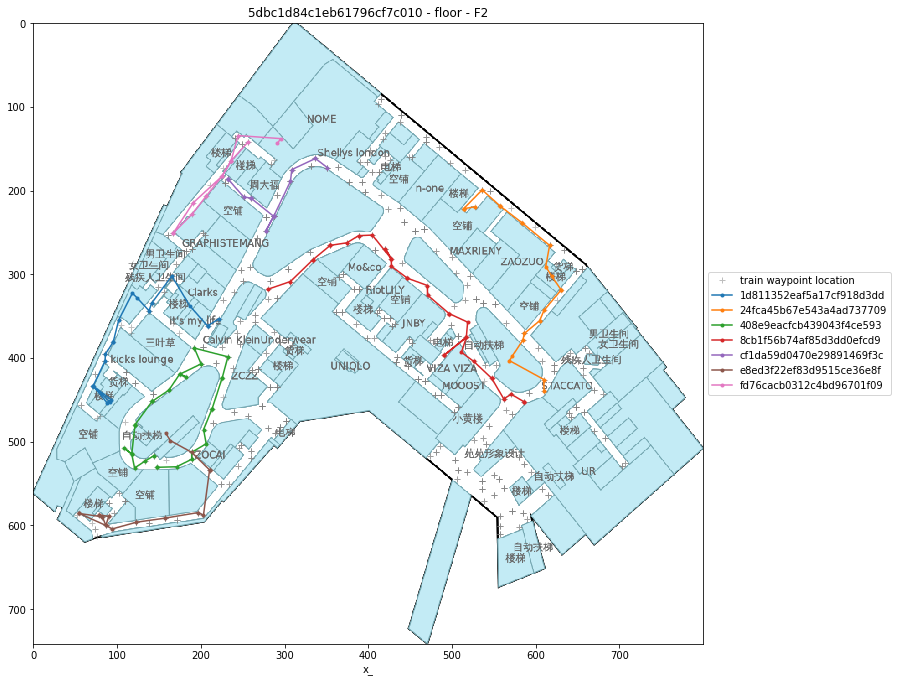

In [31]:
# Plot example after post processing
plot_preds(example_site, example_floorNo, sub_pp,
           train_waypoints, show_preds=True)
plt.show()

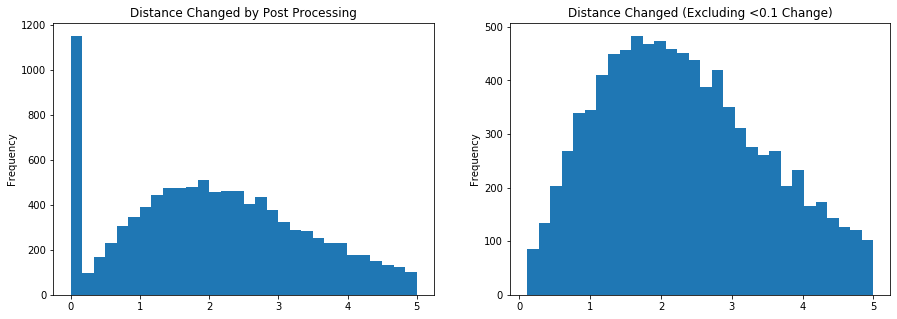

In [32]:
sub['dist_pp_change'] = np.sqrt(((sub['x'] - sub['_x_']) ** 2) + ((sub['y'] - sub['_y_']) ** 2))
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sub['dist_pp_change'].plot(kind='hist', bins=30,
                           ax=axs[0],
                           title='Distance Changed by Post Processing')
sub.query('dist_pp_change > 0.1')['dist_pp_change'] \
    .plot(kind='hist', bins=30, ax=axs[1],
          title='Distance Changed (Excluding <0.1 Change)')

plt.show()

In [33]:
sub.shape

(10133, 17)

In [34]:
## cost times2

In [35]:

tmp = sub['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
sub['site'] = tmp[0]
sub['path'] = tmp[1]
sub['timestamp'] = tmp[2].astype(float)

processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, sub.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
sub = pd.concat(dfs).sort_values('site_path_timestamp')

626it [01:44,  6.01it/s]


In [36]:
from scipy.spatial.distance import cdist

def add_xy(df):
    df['xy'] = [(x, y) for x,y in zip(df['x'], df['y'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

sub = add_xy(sub)

In [37]:

tmp = sub['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
sub['site'] = tmp[0]
sub['path'] = tmp[1]
sub['timestamp'] = tmp[2].astype(float)


ds = []
for (site, myfloor), d in sub.groupby(['site','floor']):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

sub = pd.concat(ds)

In [38]:
def snap_to_grid(sub, threshold):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_x_'] = sub['x']
    sub['_y_'] = sub['y']
    sub.loc[sub['dist'] < threshold, '_x_'] = sub.loc[sub['dist'] < threshold]['x_']
    sub.loc[sub['dist'] < threshold, '_y_'] = sub.loc[sub['dist'] < threshold]['y_']
    return sub.copy()

# Calculate the distances
sub['dist'] = np.sqrt( (sub.x-sub.x_)**2 + (sub.y-sub.y_)**2 )

sub_pp = snap_to_grid(sub, threshold=5)

sub_pp = sub_pp[['site_path_timestamp','floor','_x_','_y_','site','path']] \
    .rename(columns={'_x_':'x', '_y_':'y'})

In [39]:
sub_pp.drop_duplicates().shape

(10133, 6)

In [45]:
# df_sample = sub_pp.copy()

# df_sample["site_id"] = df_sample["site_path_timestamp"].apply(lambda x:x.split('_')[0])
# df_sample["path_id"] = df_sample["site_path_timestamp"].apply(lambda x:x.split('_')[1])
# df_sample["timestamp"] = df_sample["site_path_timestamp"].apply(lambda x:x.split('_')[2]).astype(int)
# list_site = df_sample["site_id"].unique()

# df_leak = pd.read_csv('../codeleak/df_leak.csv')
# # apply leakage waypoint
# df_sub = df_sample.copy()
# list_path = df_sub["path_id"].unique()
# for path_id in tqdm(list_path):
#     df_sub_path = df_sub.query("path_id == @path_id")
#     start_idx = df_sub.loc[df_sub["path_id"] == path_id].index.min()
#     end_idx = df_sub.loc[df_sub["path_id"] == path_id].index.max()
#     start_x = df_sub_path.at[start_idx,"x"]
#     start_y = df_sub_path.at[start_idx,"y"]
#     end_x = df_sub_path.at[end_idx,"x"]
#     end_y = df_sub_path.at[end_idx,"y"]
#     start_x_leak = df_leak.query("path_id == @path_id")["start_waypoint_x"].iloc[0]
#     start_y_leak = df_leak.query("path_id == @path_id")["start_waypoint_y"].iloc[0]
#     end_x_leak = df_leak.query("path_id == @path_id")["end_waypoint_x"].iloc[0]
#     end_y_leak = df_leak.query("path_id == @path_id")["end_waypoint_y"].iloc[0]
#     if not np.isnan(start_x_leak):
#         df_sub.at[start_idx,"x"] = start_x_leak
#         df_sub.at[start_idx,"y"] = start_y_leak
#     if not np.isnan(end_x_leak):
#         df_sub.at[end_idx,"x"] = end_x_leak
#         df_sub.at[end_idx,"y"] = end_y_leak

100%|██████████| 626/626 [00:06<00:00, 103.89it/s]


In [40]:
df_sub = sub_pp.copy()

In [41]:
sub = df_sub.copy()


In [42]:
sub[['site_path_timestamp','floor','x','y']].to_csv('sub_wifi_sensor_post.csv',index=False)


In [43]:
sub.shape

(10133, 6)